In [1]:
import sys
import os

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from sklearn.neighbors import NearestNeighbors

## Loading a data set

In [2]:
# path to github repo where 
fpath_base = '/path/to/githubrepo/AdaWaveClustering/AdaWave/syntheticData/'
fpath = fpath_base + 'waveData_5.csv'
col_names = ['feat-1', 'feat-2', 'labels']
data = pd.read_csv(fpath, names=col_names)
columns = ['feat-1', 'feat-2']
#col_names.remove('index')
#data = data[col_names]
data = data.astype({'labels': 'int32'})
print(data.shape)
data.head()

(11200, 3)


,feat-1,feat-2,labels
0,32.195047,33.400979,1
1,26.448073,25.894259,1
2,35.865967,34.057093,1
3,30.521249,30.156341,1
4,10.612704,9.262520,1


## Plotting the data in a 2D projection to get a feeling of the data distribution

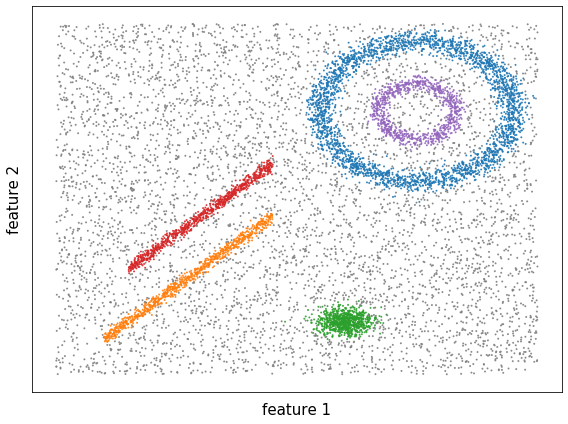

In [3]:
#pt = 1002
plt.figure(figsize=(8,6))
col_map = {0: 'tab:grey', 1: 'tab:orange', 2: 'tab:red', 3: 'tab:blue', 4:'tab:purple', 5:'tab:green', 6:'tab:cyan'}
plt.scatter(data['feat-1'], data['feat-2'], alpha=0.8, s=1, color=[col_map[sample] for sample in data.labels])
#plt.scatter(df['f1'], df['f2'], c=df['label'])
#plt.scatter(data[pt,0], data[pt,1], marker='x', s=100, lw=4, color='r')
plt.xticks([])
plt.yticks([])
plt.xlabel('feature 1', size=15, labelpad=10)
plt.ylabel('feature 2', size=15, labelpad=10)
plt.tight_layout()
plt.show()

# Get neighborhood of points

In [5]:
# 4) Get nearest neighbor indices
k_nn = 200
df_nbh = data[columns].copy()
SCALE_DATA = False
if SCALE_DATA:
    c_x = 1
    c_y = 1
    df_nbh /= df_nbh.std()
    df_nbh[cols_position] *= c_pos
    df_nbh[cols_propermtn] *= c_vel

nbh_model = NearestNeighbors(algorithm='ball_tree', metric='minkowski',
                             metric_params=None, leaf_size=30, p=2, n_jobs=-1)
nbh_model.fit(df_nbh)
nbh_distances, nbh_indices = nbh_model.kneighbors(df_nbh, k_nn, return_distance=True)

## Visualize the neighborhood

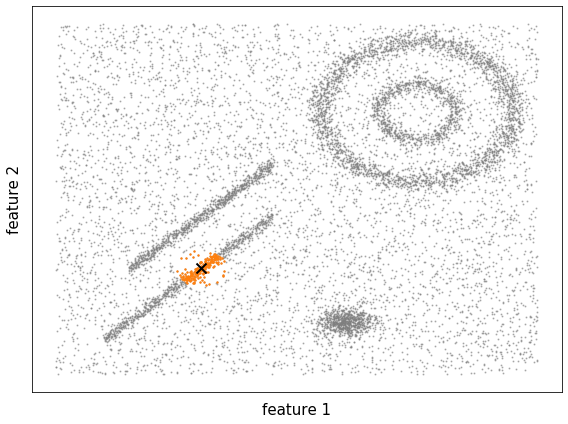

In [16]:
# Choose point to visualize
cluster_idx = 1  # cluster_idx = [0,1,2,3,4,5]
idx = 10
data_idx = np.arange(data.shape[0])[data.labels==cluster_idx][idx]
nbh_idx = nbh_indices[data_idx]


plt.figure(figsize=(8,6))
col_map = {0: 'tab:grey', 1: 'tab:orange', 2: 'tab:red', 3: 'tab:blue', 4:'tab:purple', 5:'tab:green', 6:'tab:cyan'}

plt.scatter(data['feat-1'], data['feat-2'], s=1, c='tab:grey', alpha=0.5) # , color=[col_map[sample] for sample in data.labels])
plt.scatter(data['feat-1'].iloc[nbh_idx], data['feat-2'].iloc[nbh_idx], c='tab:orange', alpha=0.9, s=2)
plt.scatter(data.iloc[data_idx]['feat-1'], data.iloc[data_idx]['feat-2'], marker='x', s=100, lw=2, color='k')
plt.xticks([])
plt.yticks([])
plt.xlabel('feature 1', size=15, labelpad=10)
plt.ylabel('feature 2', size=15, labelpad=10)
plt.tight_layout()

In [17]:
sys.path.insert(0, '/home/sebastian/Documents/PhD/pyprojects/neighborhood')
from filter_neighborhood import local_reachability_density, lrd_filter, gauss_sample

lrd_data = local_reachability_density(df_nbh, k=4, n=15)
_, nbh_indices_lrd = lrd_filter(nbh_distance=nbh_distances, nbh_indices=nbh_indices, lrd_data=lrd_data, threshold=0.6, keep_min=80)

In [18]:
_, nbh_indices_gauss = gauss_sample(nbh_distance=nbh_distances, nbh_indices=nbh_indices, alpha=1, power=1, draw_n_samples=300, weight_dist=30)

# Calculate wasserstein distances

In [19]:
# Calculate the wasserstein distance only between the nearest k_wasser neighbors
k_wasser = 200
_, nbh_indices_wasser = nbh_model.kneighbors(df_nbh, k_wasser, return_distance=True)

In [20]:
# Extract unique pairs of neighbors
calc_wasserstein_index_set = set()
for center_idx in range(nbh_indices_wasser.shape[0]):
    for idx in nbh_indices_wasser[center_idx][1:]:
        calc_wasserstein_index_set.add(frozenset({center_idx, idx}))
len(calc_wasserstein_index_set)

1296187

# Calculating wasserstein distance → this might take a while

In [21]:
dist_list = nbh_distances

row_indices = []
col_indices = []
wasserstein_dist = []
for idx_set in calc_wasserstein_index_set:
    idx_i, idx_j = idx_set
    dist = wasserstein_distance(dist_list[idx_i], dist_list[idx_j])
    wasserstein_dist.extend([dist, dist])
    row_indices.extend([idx_i, idx_j])  # symmetrical matrix
    col_indices.extend([idx_j, idx_i])  # --------||---------

In [23]:
from scipy.sparse import csr_matrix
nb_datapts = data.shape[0]
dist_mtrx = csr_matrix((wasserstein_dist, (row_indices, col_indices)), shape=(nb_datapts, nb_datapts))

In [40]:
from sklearn.cluster import DBSCAN   # DBSCAN gives us "wasserstein" connected points
db = DBSCAN(metric="precomputed", eps=0.5, min_samples=50).fit(dist_mtrx)

/home/sebastian/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/_base.py:167: EfficiencyWarning: Precomputed sparse input was not sorted by data.
  EfficiencyWarning)


In [41]:
labels = db.labels_
unique_labels = np.unique(labels)
print(unique_labels)
#for l_i in unique_labels:
    #break
    #if len(labels[labels==l_i])<200 or len(labels[labels==l_i])>2500:
    #    labels[labels==l_i] = -1
np.unique(labels)

REMOVE = False
if REMOVE:
    for li in [5,6,7]:
        labels[labels==li] = -1

np.unique(labels)

[-1  0  1  2  3  4  5  6]


array([-1,  0,  1,  2,  3,  4,  5,  6])

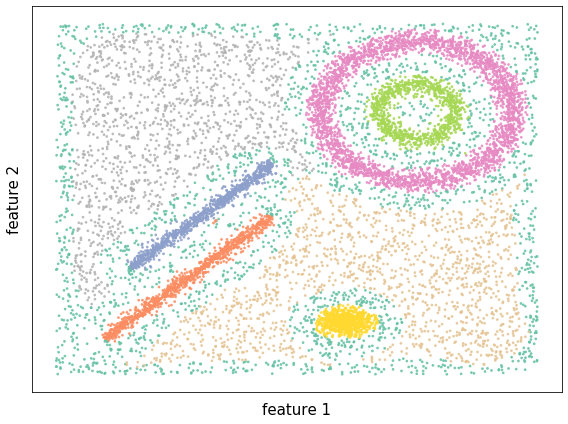

In [42]:
plt.figure(figsize=(8,6))
#col_map = {-1: 'tab:grey', 0: 'tab:orange', 1: 'tab:red', 2: 'tab:blue', 3:'tab:purple', 4:'tab:green', 5:'tab:cyan', 6:'k'}
plt.scatter(data['feat-1'], data['feat-2'], alpha=0.8, s=3, c=labels, cmap='Set2')  #, c=[col_map[sample] for sample in labels])
#plt.scatter(df['f1'], df['f2'], c=df['label'])
#plt.scatter(data[pt,0], data[pt,1], marker='x', s=100, lw=4, color='r')
plt.xticks([])
plt.yticks([])
plt.xlabel('feature 1', size=15, labelpad=10)
plt.ylabel('feature 2', size=15, labelpad=10)
plt.tight_layout()
plt.show()

In [44]:
from sklearn.metrics import adjusted_mutual_info_score
adjusted_mutual_info_score(data['labels'], labels)      # if you choose to merge the regions (set REMOVE=True 2 cells above) then you can improve the AMI to ~0.87 in the 

0.7683137053618794

# Local density estimate

In [45]:
def local_reachability_density(data, k, n, **nn_kwargs):
    """
    Reachability distance: maximum of the distance of two points and the k-distance of the second point
    In practice we only need the reachability distance between the nearest neighbors, so therefore we first build a kd/ball tree and then calculate the
    :param data: pandas DataFrame or numpy.ndarray
    :param k: integer; distance to that neighbor is calculated (for k-distance)
    :param n: Number of nearest neighbors used to calculate the LRD
    :param nn_kwargs: Kwargs for NearestNeighbors class (sklearn)
    :return: local reachability density for each point in the input data set 'data'
    """
    if not isinstance(data, (pd.DataFrame, pd.Series, np.ndarray)):
        raise TypeError('Variable "df" has to be of type pandas.DataFrame or pandas.Series')
    nn = NearestNeighbors(n_neighbors=n+1, **nn_kwargs).fit(data)
    ndist, _ = nn.kneighbors(data, n_neighbors=n+1, return_distance=True)
    # the first k distances are now set to the k-distance
    k_dist_idx = lambda i, k: i if (i>k) else k  # k-distance indices
    idx = [k_dist_idx(i, k) for i in range(1, n+1)]
    k_dist = ndist[:, idx]
    # one over LRD
    oo_lrd = np.sum(k_dist, axis=1)/n
    return 1/oo_lrd

lrd = local_reachability_density(data[columns], k=3, n=10)